## SuperVAD training

Training notebook for SuperVAD

In [1]:
# Core
import os
import json
import math
import random
import time
import IPython
from tqdm import tqdm
from contextlib import nullcontext

# Hacks to make DP work on consumer GPU
# os.environ["NCCL_SOCKET_IFNAME"] = "lo"
os.environ["NCCL_P2P_DISABLE"] = "1"

# ML
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import Tensor, nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
import torchaudio

# Local
from utils import spectogram, sliding_window
from datasets import preprocessed_audio_dataset, sample_dataset
from model import SuperVAD, Config

### Configuration

In [2]:
# Model config
model_config = Config()

# Training
train_batch = 16
train_epochs = 30
train_epoch_samples = 1000000
train_lr = 0.00001 # Being conservative here

# Validation
validation_batch = 64

### Environment
Training environment is quite simple, it is tailored for consumer GPU like `RTX 4090`. Compiler seems to be not compatible to parallel execution and compiler itself gives about 30-40% of speedup and therefore it is similar to run non-compiled code but on two GPUs therefore i am using single GPU compiled vaiant by default. Autocast seems to be working also and is enbabled too. `bfloat16` works well, but `float16` sometimes is weird and therefore i am opting to `float32` instead if `bfloat16` is not availabe.

In [3]:
# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Could have specific device
device_type = 'cuda' if 'cuda' in device else 'cpu'
enable_autocast = True
enable_anomaly_detection = False
parallel = False
compile = True

# Precision
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float32' # Using float32 since float16 sometimes not that stable
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
autocast = nullcontext() if device_type == 'cpu' or not enable_autocast else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
anomaly_detection = torch.autograd.detect_anomaly() if enable_anomaly_detection else nullcontext()
torch.set_float32_matmul_precision('high')

# Stats
experiment = "vad_release"
writer = SummaryWriter(f'runs/{experiment}')

### Dataset
[SuperVAD](https://github.com/ex3ndr/supervad-dataset) dataset that is synthesized from commercially-available samples of clean voice, noises, room response impulses and various postprocessing tricks to make it more real. Dataset has labels assigned for each 20ms token of an audio with a flag that indicates if voice is presented in this segment. SuperVAD has a 10 token context and we calculate sliding window over input data and labels and pick the last label in the window as our target since we need to predict presence of a voice in the last sample.

In [4]:
dataset_train = preprocessed_audio_dataset('./datasets/supervad-1/vad_train')
dataset_test = preprocessed_audio_dataset('./datasets/supervad-1/vad_test')

def prepare_labels(labels):    

    # Sliding window
    labels = labels.to(device, non_blocking=True)
    labels = sliding_window(labels, model_config.ctx_length, 1)

    # Use the last element in each window as target (we want to predict current token, not anything else)
    A, B, C = labels.shape
    labels = labels.reshape(A * B, C)
    # labels = torch.mean(labels, dim = 1)    # Average labels over each window
    labels = labels[..., -1] # Get last value
    labels = labels.reshape(labels.shape[0], 1) # To suppress warnings
    
    return labels

def prepare_samples(samples):

    # Spectogram
    samples = samples.to(device, non_blocking=True)
    samples = spectogram(samples)
    # samples = samples.to(device, non_blocking=True)

    # Sliding window
    samples = sliding_window(samples, model_config.ctx_length * 2, 2)

    # Reshape sliding window to batch
    A, B, C, D = samples.shape
    samples = samples.reshape(A * B, C, D)
    return samples

/home/steve/miniconda3/envs/jupyter/lib/python3.11/site-packages/torch/functional.py:650: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201450/work/aten/src/ATen/native/SpectralOps.cpp:863.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


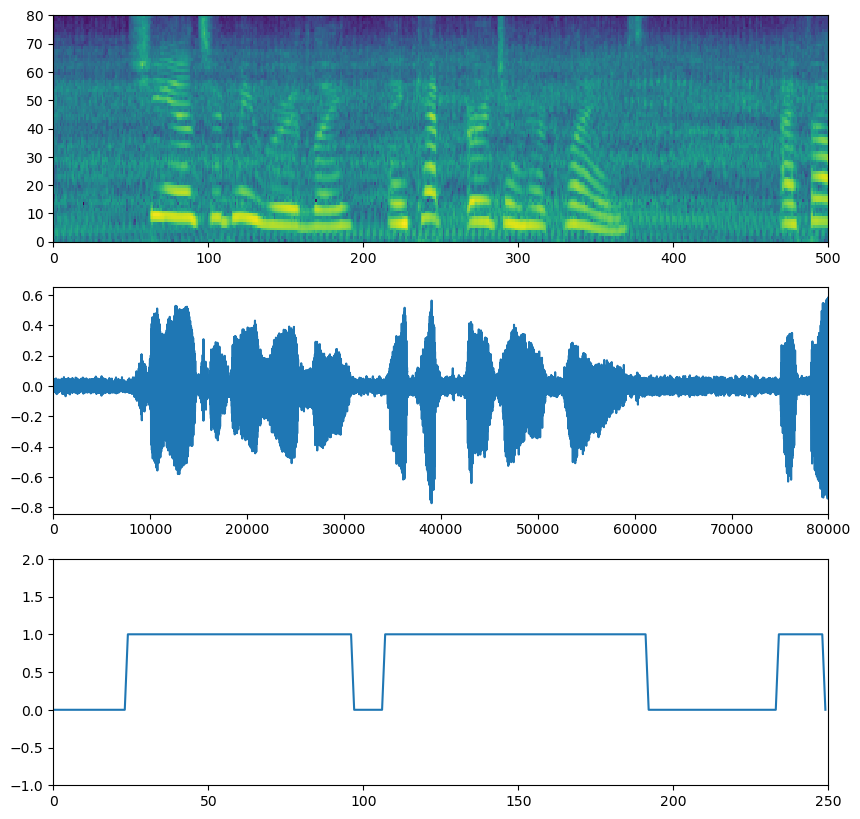

In [5]:
# value, key = sample_dataset(dataset_test)
value, key = dataset_test[22]
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,10))
ax1.pcolormesh(spectogram(value.unsqueeze(0))[0])
ax2.plot(value)
ax3.plot(key)
ax2.set_xlim([0, 80000])
ax3.set_ylim([-1, 2])
ax3.set_xlim([0, 250])
IPython.display.Audio(value, rate=16000)

### Model

In [6]:
# Model with optional compiling and parallelization
base = SuperVAD(model_config)
vad = base
if compile:
    vad = torch.compile(vad)
if parallel:
    vad = nn.DataParallel(wad)
vad.to(device)

# Save/Load
def save():
    torch.save({ 'model_state_dict': base.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),'epoch': epoch},  f'./checkpoints/{experiment}.pt')
    torch.save({ 'model_state_dict': base.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),'epoch': epoch},  f'./checkpoints/{experiment}_{epoch}.pt')
    
def load():
    global epoch
    if os.path.isfile(f'./checkpoints/{experiment}.pt'):
        checkpoint = torch.load(f'./checkpoints/{experiment}.pt')
        base.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        print(f'Loaded at #{epoch}')

# Do load
load()

### Optimizer

In [7]:
# Creating sampler and optimizer
sampler = torch.utils.data.RandomSampler(dataset_train, replacement=True, num_samples=train_epoch_samples) # We are limiting number of samples
loader = DataLoader(dataset_train, batch_size=train_batch, num_workers=8, sampler=sampler, pin_memory=True)
optimizer = optim.Adam(vad.parameters(), lr=train_lr)
epoch = 0

### Validation

In [8]:
# Prepare validation sample
random.seed(42) # Predictable
validation_samples, validation_labels = [], []
for i in range(0, validation_batch):
    s, l = sample_dataset(dataset_test)
    validation_samples.append(s)
    validation_labels.append(l)
random.seed(None)

validation_labels = torch.stack(validation_labels)
validation_labels = prepare_labels(validation_labels)

validation_samples = torch.stack(validation_samples)
validation_samples = prepare_samples(validation_samples)

# Validation function
def validate():

    # Switch to validation
    vad.eval()

    # Validation loss
    with torch.no_grad():
        with autocast:
            prediction = vad(validation_samples)
        loss = F.mse_loss(validation_labels, prediction.float())
        return loss.item() / validation_labels.shape[0]
validate()

2.879951790717133e-05

### Training

In [9]:
def train_batch(samples, labels):
    # Switch to training
    vad.train()

    # Prepare
    labels = prepare_labels(labels)
    samples = prepare_samples(samples)
    
    # Train
    with anomaly_detection:
        optimizer.zero_grad()
        with autocast:
            prediction = vad(samples)
        loss = F.mse_loss(labels, prediction.float())
        loss.backward()
        optimizer.step()

    # Stats
    return loss.detach(), labels.shape[0]

def train_epoch():
    total_loss = torch.tensor(0.0).to(device)
    total_items = torch.tensor(0).to(device)
    for i, data in enumerate(loader):
        samples, labels = data
        l, c = train_batch(samples, labels)
        total_loss = total_loss + l
        total_items = total_items + c
    return total_loss / total_items

In [ ]:
for i in range(epoch, train_epochs):
    epoch = epoch + 1

    # Train
    start = time.perf_counter()
    training_loss = train_epoch()
    duration = round((time.perf_counter() - start) * 1000)

    # Validate
    validation_loss = validate()

    # Stats
    print(f'#{epoch}: {training_loss}/{validation_loss} in {duration} ms')
    writer.add_scalar('training loss', training_loss, epoch)
    writer.add_scalar('validation loss', validation_loss, epoch)

    # Save
    save()

/home/steve/miniconda3/envs/jupyter/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/steve/miniconda3/envs/jupyter/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/steve/miniconda3/envs/jupyter/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/steve/miniconda3/envs/jupyter/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


### Evaulation
Here we are calculating total loss over all test samples and demonstrate random sample from testset and it's results. First graph is spectogram, second is labels from dataset, third one is tokens that has probability of voice greater than 0.8 and raw output of network.

In [ ]:
samples, labels = sample_dataset(dataset_test)
prediction = base.forward(prepare_samples(samples.unsqueeze(0)))
prediction = prediction.detach().cpu().numpy().reshape(-1)
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,figsize=(10,10))

ax1.pcolormesh(spectogram(samples))

ax2.plot(samples.cpu())
ax2.set_xlim([0, 80000])

ax3.plot(labels)
ax3.set_xlim([0, 240])
ax3.set_ylim([-1, 2])

ax4.plot(prediction > 0.8)
ax4.set_ylim([-1, 2])
ax4.set_xlim([0, 240])

ax5.plot(prediction)
ax5.set_ylim([-1, 2])
ax5.set_xlim([0, 240])

IPython.display.Audio(samples, rate=16000)

In [ ]:
def full_validation():
    test_loader = DataLoader(dataset_test, batch_size=validation_batch, num_workers=8)
    total_loss = torch.tensor(0.0).to(device)
    total_items = torch.tensor(0).to(device)
    for i, data in enumerate(test_loader):
        samples, labels = data
        # Prepare
        labels = prepare_labels(labels)
        samples = prepare_samples(samples)

        # Execute
        with torch.no_grad():
            with autocast:
                prediction = vad(samples)
            loss = F.mse_loss(labels, prediction.float())
            total_loss += loss.item()
            total_items += validation_labels.shape[0]
        
    return (total_loss / total_items).item()
full_validation()

### Export to ONNX
Export results to ONNX. We are using a trick to put STFT into ONNX model to avoid implementing it everywhere where model is used. We also cast result to float32 since it won't work in some environments.

In [ ]:
# Export ONNX file
class ONNXSuperVAD(nn.Module):
    def __init__(self, inner):
        super().__init__()
        self.inner = inner
    def forward(self, audio):
        return self.inner.forward(spectogram(audio)).to(torch.float32)
onnexed_wad = ONNXSuperVAD(base)
dummy = dataset_test[0][0][0:model_config.ctx_length*320].to(device).unsqueeze(0)
torch.onnx.export(onnexed_wad, dummy, experiment + ".onnx", export_params=True, input_names = ['input'], output_names = ['output'])